In [4]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import numpy as np
import torch
import math

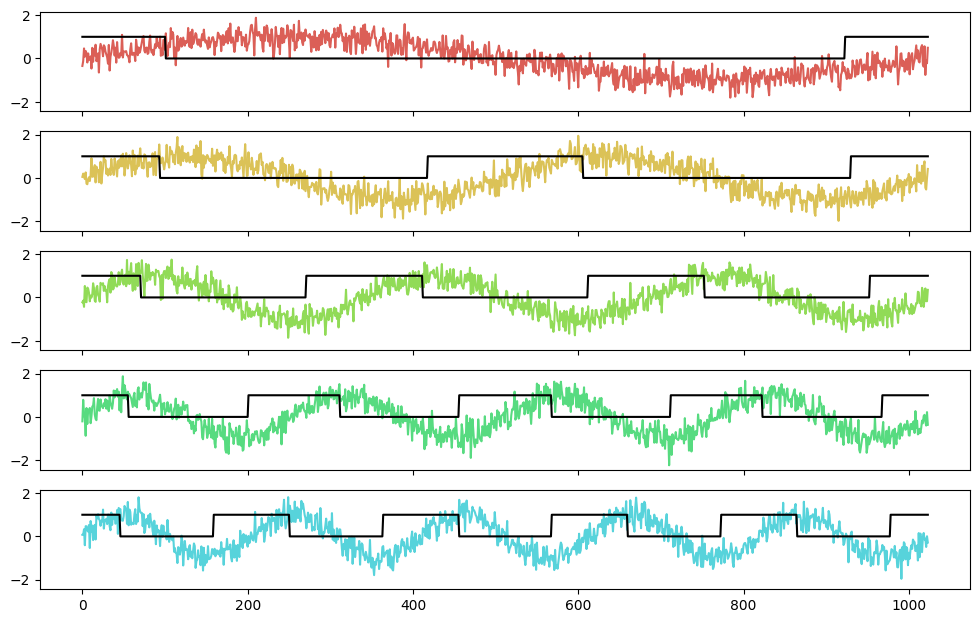

In [13]:
from torch.utils.data import Dataset, DataLoader
import scipy.stats as st
from numpy.random import Generator, PCG64

class IncreasingSine(Dataset):
    def __init__(self, size=1024, n_periods=5, noise_std=.35, seed=123):
        super().__init__()
        self.size = size
        self.n_periods = n_periods
        self.noise_std = noise_std
        self.rng = Generator(PCG64(seed))
        return
        
    def __len__(self):
        return self.n_periods
    
    def _generate_wave(self, n_periods):
        x = np.linspace(0, n_periods*2*np.pi, self.size, dtype=np.float32)
        x = np.sin(x)
        dx = np.gradient(x)
        x += self.rng.normal(0, self.noise_std, size=self.size)
        label = dx > .005
        return x, label
    
    def __getitem__(self, idx):
        x, label = self._generate_wave(idx + 1)
        return x, label
    
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    
dataset = IncreasingSine()

cpal = sns.color_palette('hls', 8)
n_periodss = list(range(2, 7))
l = len(n_periodss)
fig, axs = plt.subplots(nrows=l, sharex=True, sharey=True, figsize=(12, l*1.5))
for i, (ax, color) in enumerate(zip(axs.ravel(), cpal)):
    wave, label = dataset[i]
    ax.plot(wave, color=color, label='noisy sine')
    ax.plot(label, color='black', label='increasing')
plt.show()

In [ ]:
class Encoder(ln.Module):
    n_blocks : int=3
    init_features : int=16
    feature_scale : int=2
    kernel_width : int=3
    down_stride : int=2
        
    @nn.compact
    def __call__(self, x):
        f = self.init_features
        x = ln.Conv(features=f)
        for block in range(n_blocks):
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            x = ln.avg_pool(x, strides=(self.down_stride))
            if block != n_blocks - 1:
                f *= feature_scale
        return x
    
class Decoder(ln.Module):
    n_blocks : int=3
    init_features : int=256
    feature_scale : int=2
    kernel_width : int=3
    up_stride : int=2
        
    @nn.compact
    def __call__(self, x):
        f = self.init_features
        x = ln.ConvTranspose(f, kernel_size=(self.kernel_width,), padding='SAME')(x)
        for block in range(n_blocks):
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            if block != n_blocks - 1:
                f //= feature_scale
                x = ln.ConvTranspose(f, kernel_size=(self.kernel_width,), strides=(self.down_stride), padding='SAME')(x)
        return x